# Time Series Analysis

## -- Raghav Bali

## About Me

* **Publications**:
    * Conference Proceedings : (IEEE SmartData 2016) Real time Failure Prediction of Load Balancers and Firewalls
    * Book : R Machine Learning by Example (2016)
    * eBook : You need to know about R (2016)


* **Work Ex** :
    * Data Scientist, Intel 2015 - Present
    * Data Analyst, American Express 2014-2015
    * ERP Consultant, Infosys Ltd 2010-2012


* **Academics** :
    * M.Tech (_Gold Medalist_), IIIT-B 2012-2014
    * B.Tech, GGSIPU, Delhi 2006-2010 

## Time Series Analysis

![title](data/extrapolating.png)
source:[xkcd](https://xkcd.com/605/)

### Definition

> An ordered sequence of values of a variable at equally spaced time intervals.


A **Time Series** analysis helps us:
* Understand the underlying functions and processes that produced the observed data.
* Use this understanding for forecasting, monitoring or even feedback and feedforward control.

### Applications

* Sales Forecasting
* Inventory Projections
* Workload Projections
* Census Analysis & many more

## Visualizing Time Series Data

* One of simplest forms of data for visual observation.
* Visual representation provides a good head start for EDA.
* Most real world data is generated from a combination of underlying processes !

### Sample Code

We will be utilizing a daily visit data for a website for this discussion. The dataset is sourced from [openmv.org](http://openmv.net/info/website-traffic).

We will use ``python`` with libraries ``pandas, numpy and matplotlib``. For analysis/modeling we will depend upon ``statsmodel`` package

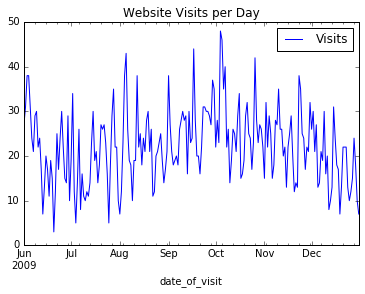

In [1]:
# standard imports
import numpy as np
import pandas as pd

# Matplot for functions
import matplotlib.pyplot as plt
%matplotlib inline

#load data
input_df = pd.read_csv(r'data\website-traffic.csv')

input_df['date_of_visit'] = pd.to_datetime(input_df.MonthDay.str.cat(input_df.Year.astype(str), sep=' '))
input_df.plot(x='date_of_visit',y='Visits', title= "Website Visits per Day")

## Types of Time Series Analysis

* Time Domain (auto-correlation, cross-correlation)
* Frequency Domain (wavelet analysis, spectral analysis)

Can also be classified as :
+ Univariate Analysis
+ Multivariate Analysis

_In this dicussion we will mainly concentrate on Time Domain Analysis_

## Components of a Time Series


### Seasonality
> Periodic fluctuations in observed data. Also termed as periodicity of series.


### Trend
> Increase or decrease in series data with respect to time.

### Residual
> Remaining signal after removal of trend and seasonality. This includes the error as well

### Decomposition

Let us now decompose a series into its contituents. We shall use ``statsmodel`` for the same.

In [4]:
# Statsmodels functions
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


# Dickey Fuller test for Stationarity
def ad_fuller_test(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

# Plot rolling stats for a time series
def plot_rolling_stats(ts):
    rolling_mean = ts.rolling(window=12,center=False).mean()
    rolling_std = ts.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# ad_fuller_test(ts_visits)
# plot_rolling_stats(ts_visits)


# extract visits as series from the dataframe
ts_visits = pd.Series(input_df.Visits.values
                      ,index=pd.date_range(
                                            input_df.date_of_visit.min()
                                            , input_df.date_of_visit.max()
                                            , freq='D')
                     )

print "Frequency of series object::",ts_visits.index.freq

# This is a workaround which would be fixed in version 0.7 onwards.
# For now pass a numpy array with specific frequency as statsmodel isnt able to use pandas fre
decomposition = seasonal_decompose(ts_visits.values,freq=24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

Frequency of series object:: <Day>


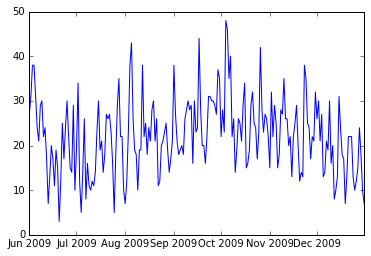

In [5]:
# Original Series
plt.plot(ts_visits.index.values,ts_visits)

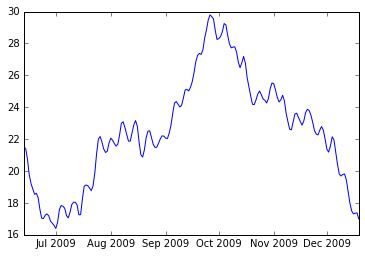

In [6]:
# Trend
plt.plot(ts_visits.index.values,trend)

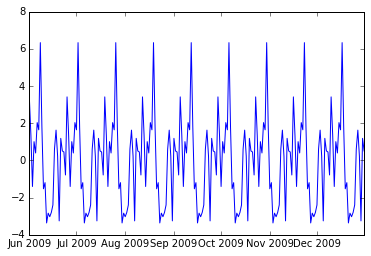

In [7]:
# Seasonality
plt.plot(ts_visits.index.values,seasonal)

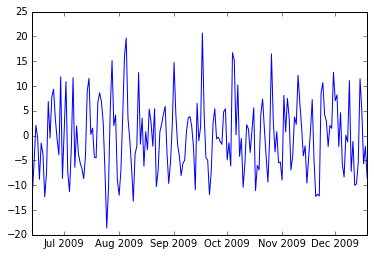

In [8]:
# Residual
plt.plot(ts_visits.index.values,residual)

## Stationarity
> A process is termed stationary if its mean, variance and autocorrelation structures do not change over time. 

### Mean
![title](data/stationary02.png)

### Variance
![title](data/stationary01.png)

### CoVariance
![title](data/stationary03.png)

### Testing Stationarity
* Visual Examination
* Dickey Fuller Test
* Other tests

### Dickey Fuller Test

> It works with a **``NULL hypothesis``** which states that the given series in *non-stationary*. If the **``Test Statistic``** is less than any of the **``Critical Values``** we reject the **``NULL hypothesis``**.


*Note:* All values are to be considered with sign!

## Methods to stationarize a non-stationary series

### Transformation : log, square root, cube root, etc.   

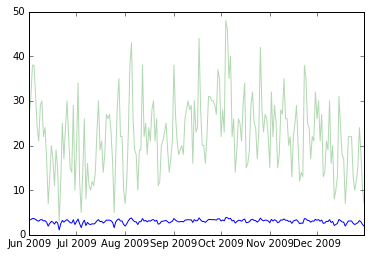

In [9]:
ts_visits_log = np.log(ts_visits)
plt.plot(ts_visits,'-',color='g',alpha=0.3)
plt.plot(ts_visits_log,color='b')

### Moving Average

```python
# Moving Average
moving_avg = ts_visits_log.rolling(window=12,center=False).mean()
plt.plot(ts_visits_log)
plt.plot(moving_avg, color='red')

ts_log_moving_avg_diff = ts_visits_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
ad_fuller_test(ts_log_moving_avg_diff)
```

### Exponential Weighted Moving Average
```python
# Exponential Weighted Moving Average
expwighted_avg = ts_visits_log.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
plt.plot(ts_visits_log)
plt.plot(expwighted_avg, color='red')

ts_log_ewma_diff = ts_visits_log - expwighted_avg
ts_log_ewma_diff.dropna(inplace=True)
ad_fuller_test(ts_log_ewma_diff)
```

In [10]:
# Using log series with a shift to make it stationary
ts_visits_log_shift = ts_visits_log - ts_visits_log.shift()
ts_visits_log_shift = ts_visits_log_shift[~np.isnan(ts_visits_log_shift)]

## Time Series Modeling

* AR
* MA
* ARMA
* ARIMA
* Exponential Smoothenin (Holt's, Holt-Winter's) and many more

## ARIMA

* **AR** : Auto Regressive

* **MA** : Moving Average

* **I** : Integrated

** Auto Regression (AR) **

> The variable of interest is being regressed on its own values



** Moving Average (MA) **

\begin{equation*}
\mathbf{M}_t =\frac{X_t+X_{t−1}+⋯+X_{t−N+1}}{N}
\end{equation*}



** Auto Regression Integrated Moving Average (ARIMA) **

* **AR** : Variable of interest is being auto-regressed by *k* terms.
 
* **MA** : The errors of regression are a linear combination of past values
 
* **I** : The series data is replaced by *i* differened values



** Holt's Exponential Smoothening (HES) **

-- Mention details here




** Auto Correlation Function (ACF) **

> Helps in identification of randomness in data. In Box_jenkin's approach it is used for model identification.


** Partial Auto Correlation Function (PACF) **

> Used in Box_jenkin's approach it is used for model identification. An AR(p) model will have *pacf* 0 at lag *p+1*


## ARIMA based Forecasting

* Stationary Series
* Non-Seasonal


Test Statistic                -1.434192e+01
p-value                        1.056524e-26
#Lags Used                     5.000000e+00
Number of Observations Used    2.070000e+02
Critical Value (5%)           -2.875606e+00
Critical Value (1%)           -3.462342e+00
Critical Value (10%)          -2.574267e+00
dtype: float64


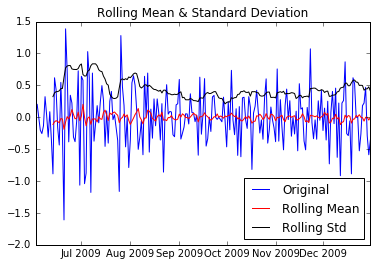

In [11]:
ad_fuller_test(ts_visits_log_shift)
plot_rolling_stats(ts_visits_log_shift)

### ARIMA params

\begin{equation*}
ARIMA (p,q,d)
\end{equation*}

* p : The AR lag.
* q : The MA lag.
* d : The lag (non-seasonal difference)

### ARIMA params

* Auto-Correlation Function
* Partial Auto-Correlation Function

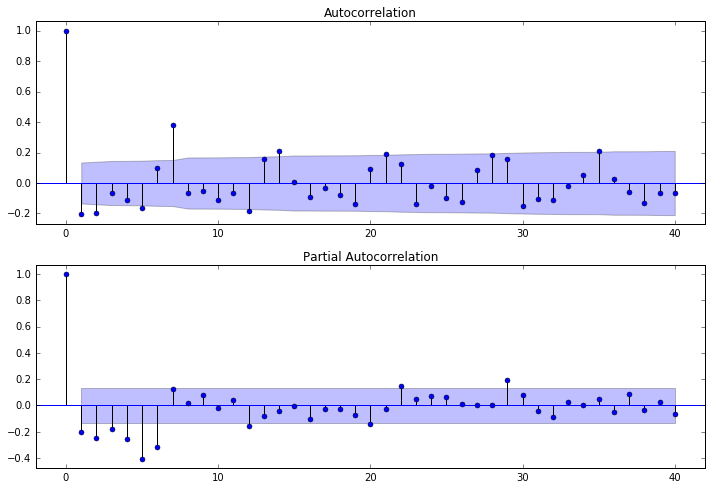

In [23]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_visits_log_shift.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_visits_log_shift, lags=40, ax=ax2)

## ARIMA Modeling

* Stationar-*ise* your series
* Plot *ACF* and *PACF*
* Identify p,q and d's

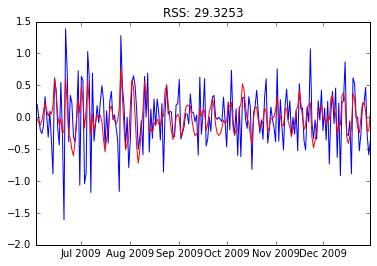

In [24]:
# Fit a model with identified p,q and d
model = ARIMA(ts_visits_log, order=(2, 1, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_visits_log_shift)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_visits_log_shift)**2))

### and just Forecast !!!

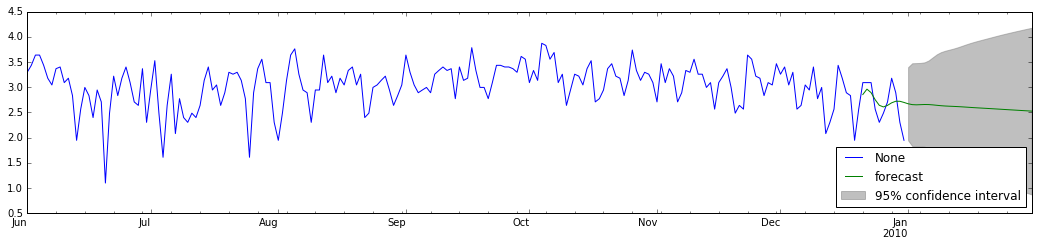

In [25]:
fig, ax = plt.subplots(figsize=(18, 4))
fig.autofmt_xdate()
ax = ts_visits_log.ix[:].plot(ax=ax)
fig = results_AR.plot_predict('2009-12-21', '2010-01-31', dynamic=True,ax=ax,plot_insample=False)
plt.show()

## Complete Notebook

The complete notebook with worked out code can be forked from : [github](https://github.com/raghavbali/python_notebooks/blob/master/time_series_analysis/website_visit_forecast.ipynb)

## Discussion

* Topics to Ponder
* Q/A

## Topics to Ponder

* CLT and Time Series
* Class Imbalance
* Model Evaluation
* Modeling Iterations

## Q and A

## References and Links

* Dateset : [OpenMV.net](http://openmv.net/info/website-traffic)
* Statsmodels : [Documentation](http://statsmodels.sourceforge.net/0.6.0)
* Central Limit Theorem  : [Wharton Lectures](http://www-stat.wharton.upenn.edu/~stine/stat910/lectures/11_clt.pdf)
* Stats Handbook : [Engineer & Stats Handbook](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm)
* SciPy 2011 Proceedings : [Time Series with Python](http://conference.scipy.org/proceedings/scipy2011/pdfs/statsmodels.pdf)

# Thank You

-- [twitter @rghv_bali](https://twitter.com/Rghv_Bali) , [linkedin bali.raghav](https://in.linkedin.com/in/raghav-bali-00412b18)